CNN Baseline classifier using train/test split datasets

In [1]:
import os
import numpy as np
import sys
print(sys.executable)
import sys
sys.path.insert(1, '../src/')
from CNN_classifier_model import CNNClassifier, train_model
from config import raw_data_path, univariate_data_path, processed_data_path
from preprocessing_modules import create_time_windows_with_labels
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
import wandb
wandb.login(key="5f15eb7efc1e0e939ccc83345338a0b8c24e2fbc")


/home/nwertheim/miniconda3/bin/python


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/nwertheim/.netrc
wandb: Currently logged in as: noorwertheim to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
import wandb

import wandb

# Optional: Define a project name and other metadata
wandb.init(
    project="Baseline CNN classifier",
    name="run-without-class-weights",  # Optional: to name the run
    config={
        "learning_rate": 0.00012403724372113712,
        "epochs": 10,
        "batch_size": 16,
    }
)


In [3]:
train_dir = os.path.join(univariate_data_path, "target_univariate_train.npy")
train_data = np.load(train_dir, allow_pickle=True)
# train_data = pd.DataFrame(train_data)
test_dir = os.path.join(univariate_data_path, "target_univariate_test.npy")
test_data = np.load(test_dir, allow_pickle=True)
# test_data = pd.DataFrame(test_data)
print(len(train_data))
print(len(test_data))
print(train_data[0])

train_windows = create_time_windows_with_labels(train_data)
test_windows = create_time_windows_with_labels(test_data)

124
32
{'record_name': np.str_('Hopper-2022_08_24_06_55_46-0000010181-0001'), 'signal': array([[ -8.77326634],
       [-16.30170858],
       [-12.15312614],
       ...,
       [  1.94513686],
       [  0.52803341],
       [  2.90890496]]), 'fs': 20, 'preterm': 1}


In [4]:
learning_rate = 0.00012403724372113712
epochs = 20
batch_size = 16
num_layers = 5
base_channels = 32
device = torch.device(device if torch.cuda.is_available() else "cpu")


In [5]:
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.utils.class_weight import compute_class_weight

from collections import Counter

# Example dataset with windows and labels
train_windows, train_labels = create_time_windows_with_labels(train_data)
test_windows, test_labels = create_time_windows_with_labels(test_data)

# Count label distribution
train_label_counts = Counter(train_labels)
test_label_counts = Counter(test_labels)

# Print the counts
print("Train label distribution:")
print(f"  Term (0): {train_label_counts[0]}")
print(f"  Preterm (1): {train_label_counts[1]}")

print("\nTest label distribution:")
print(f"  Term (0): {test_label_counts[0]}")
print(f"  Preterm (1): {test_label_counts[1]}")

# Convert to tensors
train_windows_tensor = torch.tensor(train_windows, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)
test_windows_tensor = torch.tensor(test_windows, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32)

train_dataset = TensorDataset(train_windows_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_windows_tensor, test_labels_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train label distribution:
  Term (0): 319
  Preterm (1): 752

Test label distribution:
  Term (0): 306
  Preterm (1): 593


running without class weights
Epoch 1/20 | Test Loss : 0.7018 | Train Loss: 0.5967
Epoch 2/20 | Test Loss : 0.7788 | Train Loss: 0.5802
Epoch 3/20 | Test Loss : 0.7487 | Train Loss: 0.5814
Epoch 4/20 | Test Loss : 0.6962 | Train Loss: 0.5794
Epoch 5/20 | Test Loss : 0.6809 | Train Loss: 0.5771
Epoch 6/20 | Test Loss : 0.8035 | Train Loss: 0.5748
Epoch 7/20 | Test Loss : 0.7663 | Train Loss: 0.5751
Epoch 8/20 | Test Loss : 0.7202 | Train Loss: 0.5794
Epoch 9/20 | Test Loss : 0.7490 | Train Loss: 0.5741
Epoch 10/20 | Test Loss : 0.7644 | Train Loss: 0.5776
Epoch 11/20 | Test Loss : 0.7723 | Train Loss: 0.5707
Epoch 12/20 | Test Loss : 0.7448 | Train Loss: 0.5743
Epoch 13/20 | Test Loss : 0.7536 | Train Loss: 0.5761
Epoch 14/20 | Test Loss : 0.7584 | Train Loss: 0.5701
Epoch 15/20 | Test Loss : 0.8275 | Train Loss: 0.5712
Epoch 16/20 | Test Loss : 0.7306 | Train Loss: 0.5734
Epoch 17/20 | Test Loss : 0.6720 | Train Loss: 0.5749
Epoch 18/20 | Test Loss : 0.7133 | Train Loss: 0.5713
Epoch 1

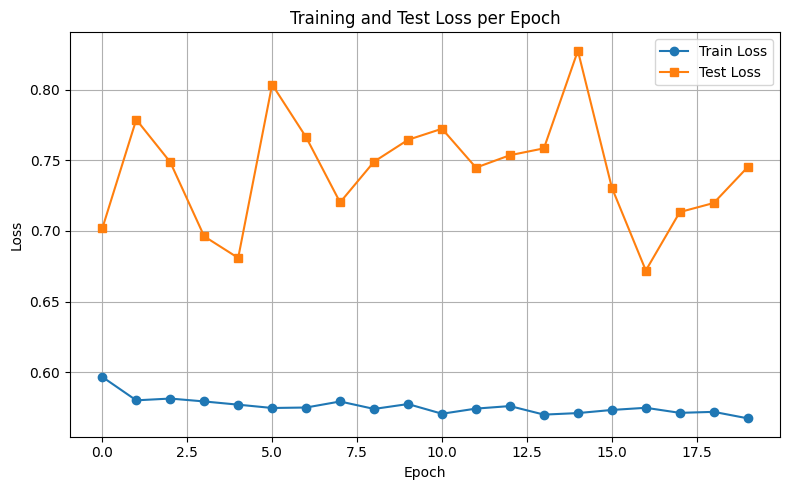

In [6]:
# Hyperparameters



input_length = 12000
model = CNNClassifier(input_length=input_length, num_layers=num_layers, base_channels=base_channels)
model = model.to(device)
wandb.watch(model, log='all', log_freq=10)
# print(model)
# Train
model = train_model(model, train_loader, test_loader, epochs=epochs, lr=learning_rate)



 Evaluation Metrics:
Accuracy:  0.6563
Precision: 0.6588
Recall:    0.9933
F1 Score:  0.7922
AUC:       0.6365
AP:        0.7278


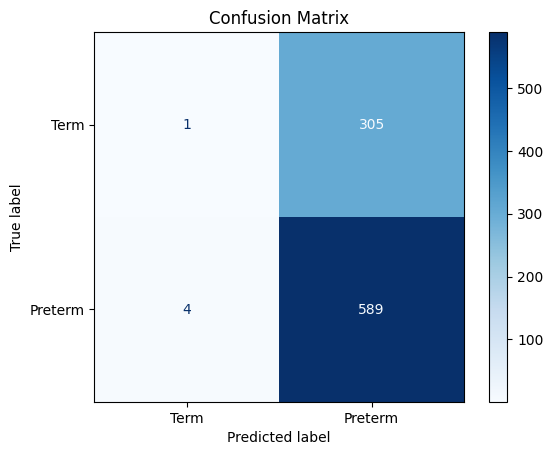

In [7]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, average_precision_score, ConfusionMatrixDisplay
)

def evaluate_model(model, test_loader, device='cuda'):
    device = torch.device(device if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.unsqueeze(1).to(device)
            y_batch = y_batch.to(device).unsqueeze(1)

            logits = model(x_batch)
            probs = torch.sigmoid(logits)

            all_probs.extend(probs.cpu().numpy().flatten())
            all_preds.extend((probs > 0.5).int().cpu().numpy().flatten())
            all_labels.extend(y_batch.cpu().numpy().flatten())

    # Convert to NumPy arrays
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    y_score = np.array(all_probs)

    # Compute metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_score)
    ap = average_precision_score(y_true, y_score)

    print("\n Evaluation Metrics:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"AUC:       {auc:.4f}")
    print(f"AP:        {ap:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Term", "Preterm"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

evaluate_model(model, test_loader)
